# Predicting Group Responsible - Initial Model Evaluation

In [1]:
%matplotlib inline

import pandas as pd
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
from IPython.display import display

# if csv isn't there:
# %run ./CreateCSVFile.py
gtd = pd.read_csv('gtd_processed_11features.csv', encoding='latin1', low_memory=False)
#gtd = gtd.tail(10000) #TODO: only use to speed up temporarily
display(gtd.head(5))
gtd.shape

,groupId,iyear,country,crit1,crit2,crit3,attacktype1,targtype1,targsubtype1,weaptype1,weapsubtype1,ransom
0,6,1970,130,1,1,1,6,7,45.0,13,0.0,1.0
1,204,1970,217,1,1,1,2,3,22.0,5,5.0,0.0
2,978,1970,218,1,1,1,1,3,25.0,5,2.0,0.0
3,679,1970,217,1,1,1,7,4,28.0,8,19.0,0.0
4,679,1970,217,1,1,1,7,2,21.0,8,20.0,0.0


(88657, 12)

Split-out validation dataset

In [3]:
array = gtd.values
seed = 188
X = array[:,1:]
Y = array[:,0]
# print X
validation_size = 0.10
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [4]:
models = []
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('GNB', GaussianNB()))
#models.append(('SVM', SVC())) #Too slow for this many samples - O(N^3)
  
results = []
names = []
scoring = 'accuracy'
 
#%timeit
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNN: 0.663458% (0.005801) - 10.24 seconds
CART: 0.712499% (0.004604) - 13.557 seconds
RF: 0.684877% (0.004442) - 112.637 seconds


### 11 Features, .Tail(10000)
LDA: 0.426000% (0.014946) - 0.313 seconds

KNN: 0.726875% (0.012071) - 0.312 seconds

CART: 0.762125% (0.011389) - 0.371 seconds

RF: 0.716222% (0.016347) - 3.136 seconds

GNB: 0.102750% (0.009401) - 0.763 seconds

SVM: 0.723875% (0.014879) - 342.715 seconds

## 11 Features, All Rows
LDA: 0.302968% (0.005750) - 6.834 seconds

KNN: 0.657032% (0.005536) - 8.244 seconds

CART: 0.706761% (0.004214) - 12.792 seconds

GNB: 0.064843% (0.003521) - 17.24 seconds

RF: 0.684877% (0.004442) - 112.637 seconds

Compare Algorithms

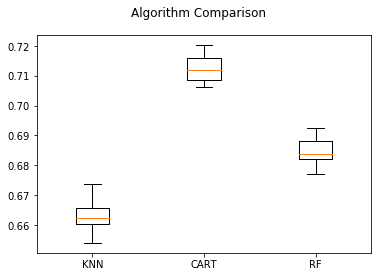

In [5]:
fig = plt.figure()
# ?plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Make predictions on validation dataset

In [6]:
# Make predictions on validation dataset
cart = DecisionTreeClassifier()
cart.fit(X_train, Y_train)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.719039025491
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         1
        1.0       1.00      1.00      1.00         1
        2.0       0.50      1.00      0.67         2
        4.0       0.50      1.00      0.67         1
        5.0       1.00      1.00      1.00         3
        6.0       0.60      0.75      0.67         4
        7.0       0.00      0.00      0.00         0
        8.0       1.00      0.50      0.67         2
        9.0       0.33      0.50      0.40         2
       10.0       1.00      1.00      1.00         1
       13.0       0.00      0.00      0.00         1
       14.0       0.00      0.00      0.00         1
       16.0       0.00      0.00      0.00         5
       18.0       0.52      0.52      0.52        50
       21.0       0.00      0.00      0.00         0
       2

/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
